# Capstone | Customer Segmentation Analysis
## Small Business | Tax Office Insights

* Student name: Miguel Santana
* Student pace: Full Time
* Scheduled project review date/time: 11/28/2020, 2 PM
* Instructor name: James Irving
* Blog post: [Medium](https://msantana269.medium.com/clustering-customer-churn-time-series-b51c9f59d691)

Follow the notebooks and analysis in the following order:

1) Data_Cleaning.ipynb

2) Clustering.ipynb

3) Customer_Churn.ipynb

## Abstract

Through data exploration and analysis of clientele data over a three-year period, recommendations for business development are provided below. The three sections of our analysis are provided in the following notebooks: Data_Cleaning.ipynb, Clustering.ipynb and Customer_Churn.ipynb. The most significant loss for the office occurs in clients between the ages of 25 and 35 coming from single income households. Our analysis outlines strategies for targeted marketing and customer retention. 

## Methodology
A business owner has tasked our team with analyzing their client base in order to build an effective targeted marketing campaign. COVID-19 has severely compromised their ability to have face to face interactions with customers and this has been a long standing cornerstone of their business layout. The goal of this notebook is to cluster the tax office's client base into clusters of customers based on distinguishable factors. K-Means clustering and principal component analysis will be used in order to process this request. Market segmentation will provide the business owner key details to be use in targeted marketing campaigns.

## Framework
The OSEMN framework will be used to navigate the project, models and interpretations culminating in actionable business recommendations. 

The OSEMN Framework

* Obtain  
* Scrub ('Data_Cleaning.ipynb')
* Explore 
* Model 
* Interpret

## Importing Packages

In [1]:
# Packages for cleaning, processing, visualizing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('mode.chained_assignment', None)
plt.style.use('seaborn-poster') 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Modeling packages
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
# Plotly Visualizations
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import plotly.graph_objects as go
# For offline use
cf.go_offline()

# OBTAIN
### Importing Data | Tax Returns

In [4]:
df = pd.read_csv('taxdata.csv', index_col='LastDate', parse_dates=True)

In [5]:
# Initial data observations
print(df.shape)

(1467, 31)


### Verifying Null Data

In [6]:
print('Missing Values : ', df.isnull().sum().values.sum()) # null values
# print('Missing Values: \n', df.isna().sum()) # unique values per column

Missing Values :  0


# SCRUB
#### Please see 'Data_Cleaning.ipynb' for preliminary data cleaning and 'Customer_Churn.ipynb' for customer churn analysis.

## Simplifying Data Frame
#### Selecting top features per Customer Churn Analysis

In [7]:
total = len(df)
yuma = len(df[df['County'] == 'YUMA'])
percent = yuma/total
print('The client base is primarily in the City/County of Yuma. Of the clients, {} reside in Yuma County. As a result, the regional columns will be dropped.'.format(percent))

The client base is primarily in the City/County of Yuma. Of the clients, 0.9475119291070211 reside in Yuma County. As a result, the regional columns will be dropped.


In [8]:
# Selected features for clustering
df = df[['FamSize','ID','Gender','Age','Email','Household_Income','Preparer',
         'FedTax','AGI','Paid','Month','Day','Customer_Churn']]

#### Cleaning Numerical Columns

In [9]:
# Converting numerical values to integers
for num_cols in df.select_dtypes('number').columns: df[num_cols] = df[num_cols].astype(int)

#### Month & Day | Name to Numerical Value

In [10]:
# Converting months to numerical values
monthvals = {'April':4, 'March':3, 'June':6, 'February':2, 'January':1, 'August':8, 
             'September':9, 'May':5, 'July':7, 'October':10, 'November':11}

df['Month'] = df['Month'].map(monthvals)

In [11]:
# Converting days to numerical values
dayvals = {'Tuesday':2, 'Thursday':4, 'Saturday':6, 'Monday':1, 'Sunday':7, 
           'Wednesday':3, 'Friday':5}
df['Day'] = df['Day'].map(dayvals)

## Feature Engineering
#### Preparer | Processed by Preparer or Admin

In [12]:
df['Preparer'] = df['Preparer'].map(lambda s :0 if s == 'ADMIN' else 1)

### Binary Columns | Updates for Machine Learning

In [13]:
# Cleaning customer churn
df['Customer_Churn'] = df['Customer_Churn'].replace('return','No')

In [14]:
# Dropping new customers in order to perform a fair assessment 
df = df[df['Customer_Churn'] != 'New']

In [15]:
df['Household_Income'] = df['Household_Income'].map(lambda s :1 if s == 'Single Income' else 2)
df['Gender'] = df['Gender'].map(lambda s :1 if s == 'MALE' else 0)
df['Email'] = df['Email'].map(lambda s :1 if s == 'Yes' else 0)
df['Customer_Churn'] = df['Customer_Churn'].map(lambda s :1 if s == 'Yes' else 0)

<div class="alert alert-block alert-info">

Binary categorical columns will be converted to zero's and one's in order to include them in our machine learning algorithm. 

</div>

In [16]:
# Creating a dataframe of unique customer IDs
df['ID'] = df['ID'].astype('object')
clients = df.groupby('ID').last().reset_index().dropna(axis=0) # sorting by last occurance

In [17]:
print(clients.shape)
clients.head()

(1226, 13)


,ID,FamSize,Gender,Age,Email,Household_Income,Preparer,FedTax,AGI,Paid,Month,Day,Customer_Churn
0,259,2,1,54,0,2,1,1409,8527,230,4,2,0
1,300,2,1,36,0,1,1,6745,65623,230,2,5,0
2,405,2,1,56,0,2,1,6806,65320,145,4,3,0
3,698,4,0,32,0,1,0,0,24301,0,1,4,0
4,717,4,0,31,0,1,1,0,24332,0,2,5,0


# Exploratory Data Analysis

In [18]:
clients.iplot(kind='box')

<div class="alert alert-block alert-info">

The data is relatively well distributed with only Federal Tax (owed) and Adjusted Gross Income having significant outliers. This makes sense as a larger income earned results in higher federal tax liability. 

</div>

## Multicollinearity

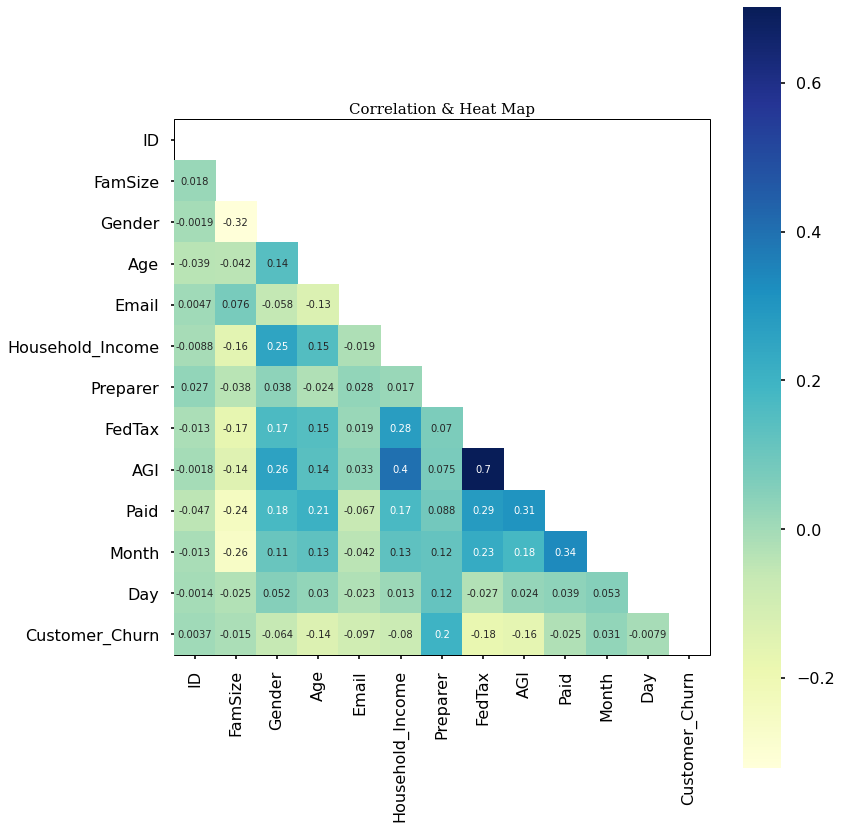

In [19]:
corr = clients.corr() # analyzing correlation
fig, ax = plt.subplots(figsize=(12,14))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask, square=True, annot=True, cmap='YlGnBu')
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')
ax.set_title('Correlation & Heat Map', fontsize=15, fontfamily='serif')
plt.show()

# Customer Segmentation
### Scale Data

In [20]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(clients)

In [21]:
# observing scaled data
df_scaled.shape

(1226, 13)

## Principal Component Analysis | Original Dataset
Reducing dimensionality while keeping the original information intact using generated components. 

In [22]:
# Reducing to two columns
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(df_scaled) # passing scaled data

In [23]:
# creating dataframe out of 2 component result
pca_df = pd.DataFrame(data = principal_comp, columns=['PCA1','PCA2'])

## K-Means Clustering
K-Means clustering will be used to group customers together without a specific target variable. The algorithm will cluster clients based on similar attributes using euclidian distance (between points).

#### Optimal Number of Clusters | Elbow Method & Silhouette Coefficient
The optimal number number of clusters via the elbow method uses within cluster sum of squares (WCSS) values to establish the optimal data point to centroid distance. This is then used to segment data points into the optimal number of clusters.

In [24]:
scores = [] # scores for elbow method
range_values = range(1,20)
for i in range_values:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(pca_df)
    scores.append(kmeans.inertia_) # inertia is the WCSS parameter

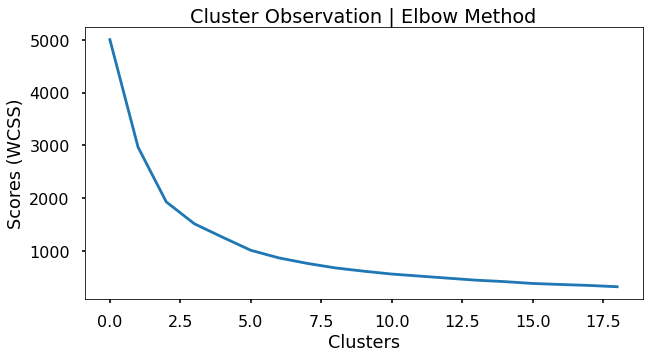

In [25]:
# Cluster Observation
plt.figure(figsize=(10,5))
plt.plot(scores)
plt.title('Cluster Observation | Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('Scores (WCSS)')
plt.show()

#### Plotly Cluster Observation | Interactive Plot

In [26]:
# # Cluster Observation
# fig = go.Figure(data=go.Scatter(y=scores))

# fig.update_layout(title='Cluster Observation | Elbow Method',xaxis_title='Clusters',
#                   yaxis_title='Scores (WCSS)',font=dict(family='Courier New, monospace',
#                                                         size=14,color='black'))
# fig.show()

#### Silhouette Coefficient

In [27]:
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(pca_df)
    label = kmeans.labels_
    sil_coeff = silhouette_score(pca_df, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.38220825355212495
For n_clusters=3, The Silhouette Coefficient is 0.37707311618354344
For n_clusters=4, The Silhouette Coefficient is 0.35703777559187755
For n_clusters=5, The Silhouette Coefficient is 0.3394180575335465
For n_clusters=6, The Silhouette Coefficient is 0.359974021633446
For n_clusters=7, The Silhouette Coefficient is 0.34250439593468285
For n_clusters=8, The Silhouette Coefficient is 0.3489072744142943
For n_clusters=9, The Silhouette Coefficient is 0.3503347782456784
For n_clusters=10, The Silhouette Coefficient is 0.3442883482801568


<div class="alert alert-block alert-info">

Based on the WCSS and Silhouette scores, the elbow method illustrates that 2 or 3 is the optimal number of clusters.

</div>

### (2) Clusters - Fitting Model | K-Means 

In [28]:
# 2 Clusters
km = cluster.KMeans(n_clusters=2, max_iter=300, random_state=101)
pca_df['Two_Clusters'] = km.fit_predict(pca_df)

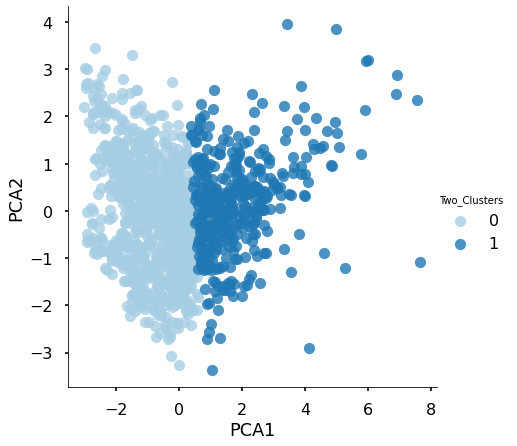

In [29]:
# Two cluster scatterplot/seaborn
sns.lmplot(x='PCA1', y='PCA2', data=pca_df, fit_reg=False, hue='Two_Clusters',
           palette='Paired',size=6,aspect=1);

#### Plotly Two-Cluster Scatterplot | Interactive Plot

In [30]:
# # Two cluster scatterplot
# pca_df['Two_Clusters'] = pca_df['Two_Clusters'].astype('object')
# fig = px.scatter(pca_df, x='PCA1',y='PCA2',color='Two_Clusters',color_discrete_sequence=['red', 'blue'],
#                  title='Two Cluster Customer Segmentation')
# fig.update_layout(title_font_size=15)
# fig.show()

### (3) Clusters - Fitting Model | K-Means 

In [31]:
# 3 Clusters
km = cluster.KMeans(n_clusters=3, max_iter=300, random_state=101)
pca_df['Three_Clusters'] = km.fit_predict(pca_df)

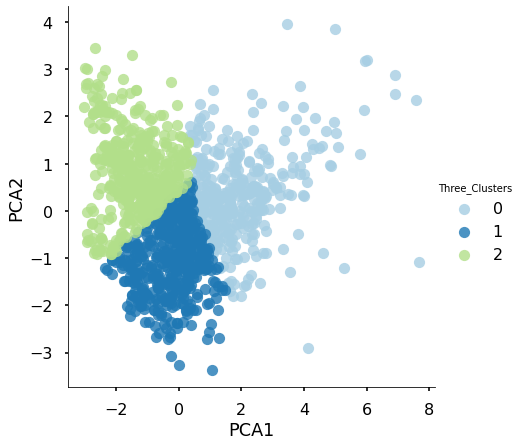

In [32]:
# Three cluster scatterplot/seaborn
sns.lmplot(x='PCA1', y='PCA2', data=pca_df, fit_reg=False, hue='Three_Clusters',
           palette='Paired',size=6,aspect=1);

#### Plotly Three-Cluster Scatterplot | Interactive Plot

In [33]:
# # Two cluster scatterplot
# pca_df['Three_Clusters'] = pca_df['Three_Clusters'].astype('object')
# fig = px.scatter(pca_df, x='PCA1',y='PCA2',color='Three_Clusters',
#                  color_discrete_sequence=['red','blue','green'],
#                  title='Three Cluster Customer Segmentation')
# fig.update_layout(title_font_size=15)
# fig.show()

# Cluster Analysis

In [34]:
# Create new dataframe | original with cluster ID
df_cluster = pd.concat([clients,pca_df],axis=1)

## (2) Clusters

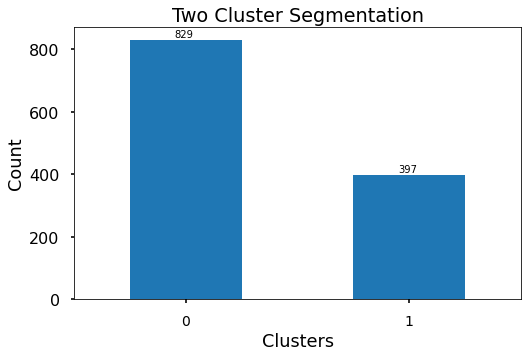

In [35]:
plt.figure(figsize=(8,5))
ax = df_cluster.drop(['Three_Clusters','PCA1','PCA2'],axis=1).groupby('Two_Clusters')['ID'].agg('count').plot(kind='bar')
ax.set(xlabel='Clusters', ylabel='Count', title='Two Cluster Segmentation')
for a in ax.patches:
    ax.text(a.get_x()+0.2, a.get_height()+10,str(a.get_height()))
for a in ax.get_xticklabels():
    a.set_rotation(0)
    a.set_size(14)

#### Plotly Two-Cluster Segmentation | Interactive Plot

In [36]:
# ax = df_cluster.drop(['Three_Clusters','PCA1','PCA2'],axis=1).groupby('Two_Clusters')['ID'].agg('count')
# ax.iplot(kind='bar',title='Two Cluster Comparison',xTitle='Clusters',yTitle='Count',colors='blue')

In [37]:
two = df_cluster.drop(['Three_Clusters','ID','PCA1','PCA2'],axis=1).groupby('Two_Clusters').mean().head()
two.style.background_gradient(cmap='Reds')

,FamSize,Gender,Age,Email,Household_Income,Preparer,FedTax,AGI,Paid,Month,Day,Customer_Churn
Two_Clusters,,,,,,,,,,,,
0,2.634499,0.499397,42.579011,0.158022,1.054282,0.885404,563.574186,27554.851628,103.002413,2.388420,3.276236,0.324487
1,1.891688,0.911839,52.491184,0.128463,1.539043,0.921914,4813.743073,68471.128463,180.639798,3.287154,3.430730,0.128463


#### Two Cluster Analysis

<div class="alert alert-block alert-info">

The two cluster segmentation reveals several key distinctions between groups. 

Cluster zero has primarily:

* Larger family (kids), even distribution of genders
* 10 years younger than second cluster (average)
* Single income households
* Significantly lower income and federal tax owed
* Significantly lower payment for services
* Processed mid-week typically mid February. 
    * Larger group, most churn

Cluster one has primarily:

* Smaller family (single/married/single + child), mostly male
* 10 years older than first cluster (average)
* Significantly higher income and federal tax owed
* Significantly higher payment for services
* Processed mid week typically early March. 
    * Smaller Group

</div>

## (3) Clusters

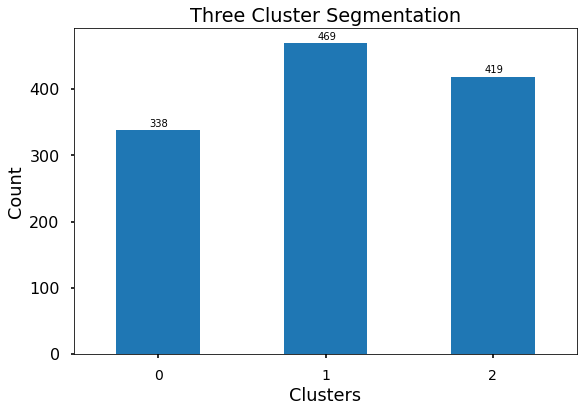

In [38]:
plt.figure(figsize=(9,6))
ax = df_cluster.drop(['Two_Clusters','PCA1','PCA2'],axis=1).groupby('Three_Clusters')['ID'].agg('count').plot(kind='bar')
ax.set(xlabel='Clusters', ylabel='Count', title='Three Cluster Segmentation')
for a in ax.patches:
    ax.text(a.get_x()+0.2, a.get_height()+6,str(a.get_height()))
for a in ax.get_xticklabels():
    a.set_rotation(0)
    a.set_size(14)

#### Plotly Three-Cluster Segmentation | Interactive Plot

In [39]:
# ax = df_cluster.drop(['Two_Clusters','PCA1','PCA2'],axis=1).groupby('Three_Clusters')['ID'].agg('count')
# ax.iplot(kind='bar',title='Three Cluster Comparison',xTitle='Clusters',yTitle='Count',colors='green')

In [40]:
three = df_cluster.drop(['Two_Clusters','ID','PCA1','PCA2'],axis=1).groupby('Three_Clusters').mean().head()
three.style.background_gradient(cmap='Reds')

,FamSize,Gender,Age,Email,Household_Income,Preparer,FedTax,AGI,Paid,Month,Day,Customer_Churn
Three_Clusters,,,,,,,,,,,,
0,1.934911,0.911243,52.127219,0.150888,1.591716,0.908284,5443.704142,74294.372781,179.109467,3.201183,3.387574,0.082840
1,1.955224,0.673774,44.869936,0.059701,1.078891,0.997868,684.767591,28835.840085,143.300640,2.961620,3.660981,0.509595
2,3.255370,0.362768,41.704057,0.245823,1.052506,0.775656,518.212411,27184.971360,70.062053,1.942721,2.902148,0.126492


#### Three Cluster Analysis

<div class="alert alert-block alert-info">

The three cluster segmentation reveals several key distinctions between groups. 

Cluster zero has primarily:

* Smaller family (single/married/single + child), mostly male
* Older clients, even distribution of single/dual income households
* Highest income, federal tax owed and fees paid for service
* Processed mid-week, typically mid March
    * Smallest group, lowest churn

Cluster one has primarily:

* Smaller family (single/married/single + child), male and female
* Mid-range age, mostly single income households
* Mid income and federal tax owed (close to lowest)
* Mid fees charged for services (36 dollars lower than top cluster)
* Processed latest in the week, typically late February
    * Largest group, largest churn

Cluster two has primarily:

* Larger family (kids), mostly female
* Youngest age, mostly single income households
* Lowest income and federal tax owed
* Lowest fee paid (50 percent of the next cluster up)
* Processed earliest in the week, typically late February
    * Middle Size Group, middle churn
    
</div>

# Conclusion, Insights and Future Work

### Conclusion
The dataset offered various consumer trends and illustrated multiple areas of opportunity. The client base was separated into using two and three clusters. While the two cluster segmentation proved effective at distinguishing between groups, the key factors in the larger group (potential target) were standard figures seen throughout this dataset. Creating a marketing strategy on this segmentation would have left room for significant error in strategy. 

Three Clusters
The three segment group offered additional insight into customer trends. Cluster (1) represented the largest group and the highest customer churn with client features that include:

* Smaller family sizes, if married no kids
* Single income households
* Second in income and tax owed (values very similar to cluster (2) with lowest values)
* Second in fees charged - twice as much as the average value for cluster 2 (similar income/tax owed).
* Processed late in the week, typically in late February

This demographic is should be highly represented when creating any targeted marketing campaigns in the new year. 

<div class="alert alert-block alert-info">
    
Business Recommendations, future work and limitations to our study are provided in our final analysis provided in the jupyter notebook 'Customer_Churn.ipynb'. 

</div>

# Notebooks
Please see our jupyter notebooks 'Data_Cleaning.ipynb' and 'Customer_Churn.ipynb' for additional analysis.